In [1]:
import os

import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from scipy.ndimage import uniform_filter1d

from lcdb.analysis.plot import plot_learning_curves
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

update_matplotlib_rc()
# figsize = figure_size(252 * 1.8, 1.0)
figsize = figure_size(252 * 1.0, 1.0)

## Loading The Data

In [2]:
dataset = "fcnet_naval_propulsion_data"
# dataset = "fcnet_parkinsons_telemonitoring_data"
# dataset = "fcnet_protein_structure_data"
# dataset = "fcnet_slice_localization_data"

def load_dataset(dataset):
    path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data/fcnet_tabular_benchmarks"
    path = os.path.join(path, f"{dataset}.hdf5")
    f = h5py.File(path, "r")
    return f

f = load_dataset(dataset)

num_elements = len(f.keys())
print(f"{num_elements=}")

# Example Keys
for k in f.keys():
    print(k)
    print(type(k))
    break
    
# Available Keys
f[k].keys()

num_elements=62208
{"activation_fn_1": "relu", "activation_fn_2": "relu", "batch_size": 16, "dropout_1": 0.0, "dropout_2": 0.0, "init_lr": 0.0005, "lr_schedule": "const", "n_units_1": 128, "n_units_2": 128}
<class 'str'>


<KeysViewHDF5 ['final_test_error', 'n_params', 'runtime', 'train_loss', 'train_mse', 'valid_loss', 'valid_mse']>

In [3]:
np.shape(f[k]["final_test_error"])

(4,)

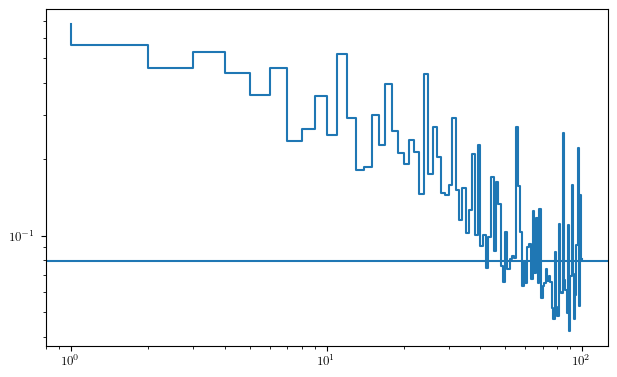

In [4]:
# Checking a single curve
all_keys = list(f.keys())
k = all_keys[np.random.randint(len(all_keys))]

y = f[k]["valid_loss"][0]
x = np.arange(1, len(y)+1)
plt.step(x, y, where="pre", label="valid")

y = f[k]["final_test_error"][0]
plt.axhline(y, label="test")

plt.xscale("log")
plt.yscale("log")
plt.show()

In [5]:
y = list(f[k]["final_test_error"])
print(y)


[0.07943848, 0.070982985, 0.053819284, 0.16138138]


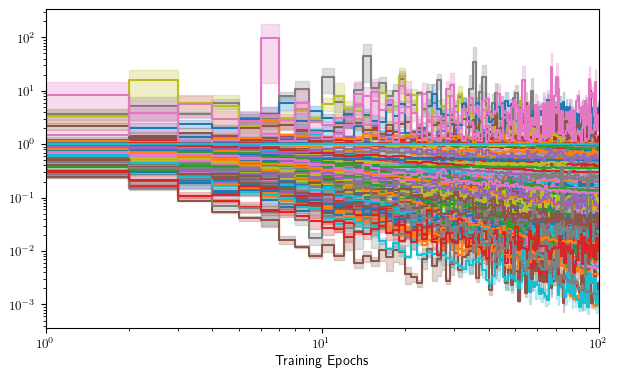

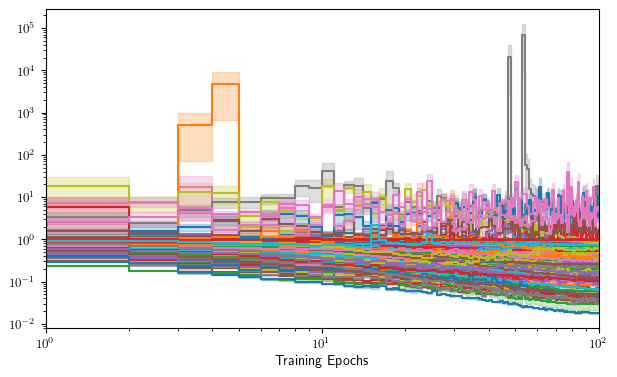

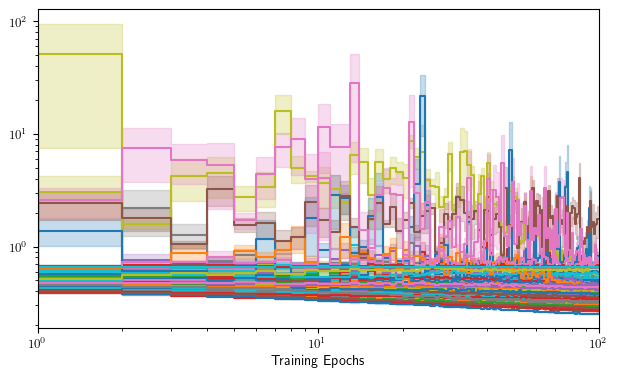

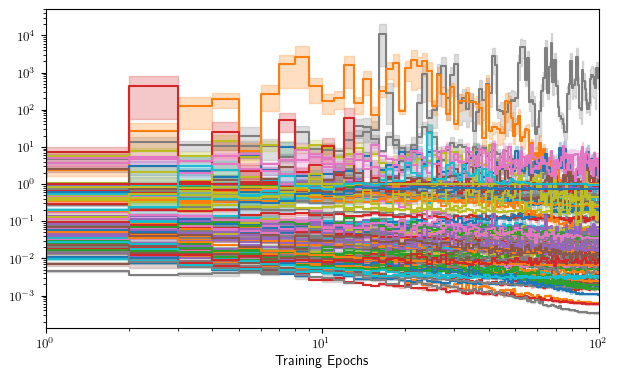

In [6]:
cmap = mpl.colormaps["tab10"]

# Checking some raw curves
datasets = [
    "naval_propulsion", 
    "parkinsons_telemonitoring", 
    "protein_structure", 
    "slice_localization"
]

for d in datasets:
    f = load_dataset(f"fcnet_{d}_data")
    
    y_list = []
    num_curves = 200
    # for i, k in enumerate(f.keys()):
    rs = np.random.RandomState(42)
    selection = rs.choice(list(f.keys()), size=100, replace=False)
    for i, k in enumerate(selection):

        # y = f[k]["valid_loss"][0]
        y = np.array(f[k]["valid_loss"])
        y_mean = np.mean(y, axis=0)
        y_stde = np.std(y, axis=0) / np.sqrt(y.shape[0])
        x = np.arange(1, y.shape[1]+1)

        plt.step(x, y_mean, where="pre", color=cmap(i%10))
        plt.fill_between(x, y_mean-y_stde, y_mean+y_stde, step="pre", alpha=0.25, color=cmap(i%10))

        y_list.append(y)

        if i > num_curves: break

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1, 100)
    plt.xlabel("Training Epochs")
    # plt.ylabel("Validation RMSE")
    plt.savefig(f"figures/hpobench/learning_curves_{d}_linear_scale.png", bbox_inches="tight")
    # plt.savefig(f"learning_curves_hpobench_{d}.png", bbox_inches="tight")
    plt.show()

## Rank Correlation

0it [00:00, ?it/s]

Mean Corr on fcnet_naval_propulsion_data: 0.82


0it [00:00, ?it/s]

Mean Corr on (B) fcnet_naval_propulsion_data: 0.80


0it [00:00, ?it/s]

Mean Corr on fcnet_parkinsons_telemonitoring_data: 0.86


0it [00:00, ?it/s]

Mean Corr on (B) fcnet_parkinsons_telemonitoring_data: 0.86


0it [00:00, ?it/s]

Mean Corr on fcnet_protein_structure_data: 0.87


0it [00:00, ?it/s]

Mean Corr on (B) fcnet_protein_structure_data: 0.89


0it [00:00, ?it/s]

Mean Corr on fcnet_slice_localization_data: 0.86


0it [00:00, ?it/s]

Mean Corr on (B) fcnet_slice_localization_data: 0.87


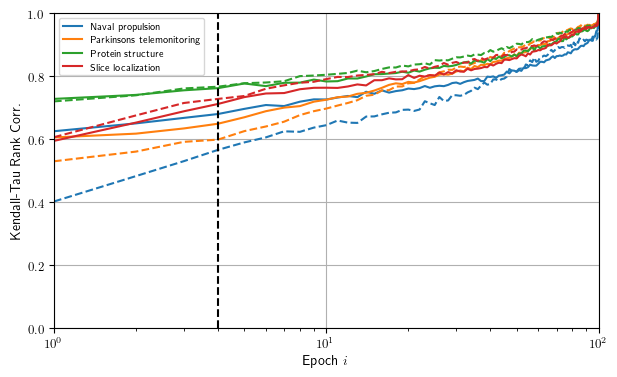

In [7]:
from scipy.stats import spearmanr, kendalltau


def get_rank_corr(f, num_models, mode="spearman", random=True, random_state=None, metric_value_baseline=None):
    assert mode in ["spearman", "kendall"]

    y_list = []
    y_last_perf = []
    rs = np.random.RandomState(random_state)
    if random:
        selection = rs.choice(list(f.keys()), size=num_models, replace=False)
    else:
        selection = list(f.keys())[:num_models]
    for i, k in tqdm(enumerate(selection)):
        y = np.mean(f[k]["valid_loss"], axis=0)
        if metric_value_baseline is not None and y[0] > metric_value_baseline:
            continue
        y_last_perf.append(y[-1])
        y_list.append(y)
    y_list = np.array(y_list)
    if mode == "spearman":
        corr_list = [spearmanr(y_list[:,i], y_last_perf)[0] for i in range(y_list.shape[-1])]
    else:
        corr_list = [kendalltau(y_list[:,i], y_last_perf)[0] for i in range(y_list.shape[-1])]
    return corr_list

num_models = 500
mode = "kendall"

datasets = ["fcnet_naval_propulsion_data", "fcnet_parkinsons_telemonitoring_data", "fcnet_protein_structure_data", "fcnet_slice_localization_data"]

plt.figure()


for i, dataset in enumerate(datasets):
    f = load_dataset(dataset)
    corr_list = get_rank_corr(f, num_models, mode=mode, metric_value_baseline=None)
    mean_corr = np.mean(corr_list)
    print(f"Mean Corr on {dataset}: {mean_corr:.2f}")

    plt.plot(np.arange(len(corr_list))+1, corr_list, label=dataset[6:-5].replace("_", " ").capitalize(), color=f"C{i}")
    
    corr_list = get_rank_corr(f, num_models, mode=mode, metric_value_baseline=1.0)
    mean_corr = np.mean(corr_list)
    print(f"Mean Corr on (B) {dataset}: {mean_corr:.2f}")

    plt.plot(np.arange(len(corr_list))+1, corr_list, color=f"C{i}", linestyle="--")
    
plt.axvline(x=4, linestyle="--", color="black")
plt.legend()
plt.xscale("log")
plt.grid()
plt.ylim(0,1)
plt.xlim(1, 100)

if mode == "Spearman":
    plt.ylabel("Spearman Rank Corr.")
else:
    plt.ylabel("Kendall-Tau Rank Corr.")
    
plt.xlabel(r"Epoch $i$")

plt.tight_layout()

plt.savefig(f"figures/hpobench/{mode}_corr_hpobench.png", dpi=360)

plt.show()

## Stability of the ranking

M.shape=(500, 100)
R.shape=(500, 100)


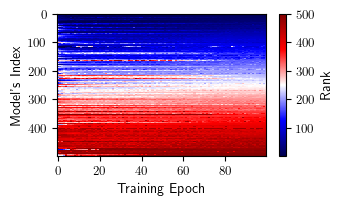

In [14]:
from scipy.stats import rankdata

# dataset = "naval_propulsion"
# dataset = "parkinsons_telemonitoring"
# dataset = "protein_structure"
dataset = "slice_localization"

f = load_dataset(f"fcnet_{dataset}_data")

random_state = 42
rs = np.random.RandomState(random_state)
keys = list(f.keys())
# num_models = len(keys) 
num_models = 500

selection = rs.choice(keys, size=num_models, replace=False)

M = []
for i, k in enumerate(selection):
    C = np.mean(f[k]["valid_loss"], axis=0).tolist()
    M.append(C)
M = np.asarray(M)
print(f"{M.shape=}")

# ranking matrix per step
R = rankdata(M, axis=0)
print(f"{R.shape=}")

idx_sorting = np.argsort(R[:,-1])

fig, ax = plt.subplots(figsize=figsize)
plt.imshow(R[idx_sorting], cmap="seismic", interpolation="nearest", aspect="auto")
plt.colorbar(label="Rank")
plt.xlabel("Training Epoch")
plt.ylabel("Model's Index")
plt.tight_layout()
plt.savefig(f"figures/hpobench/heatmap_ranks_{dataset}.png")
plt.show()

-390691.40625


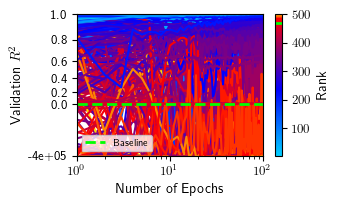

In [15]:
anchor_values = [np.arange(1, M.shape[1] + 1) for _ in range(M.shape[0])]

# the score is the R2 score = 1 - MSE/MSE_baseline where MSE_baseline is the MSE of a constant predictor
# as the dataset is normalized, the MSE_baseline is 1.0
score_values =  1 - M

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    score_values,
    ax=ax,
    metric_value_baseline=0.0,
    plot_worse_than_baseline=True,
    mode="max",
)
ax.axhline(
    0.0,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Baseline",
)

x_min = np.min(score_values)
def forward(x):
    x = np.exp(x) 
    return x

def inverse(x):
    x = np.log(x)
    return x


ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Validation $R^2$")
ax.legend(loc="lower left")
ax.set_xscale("log")
ax.set_yscale("function", functions=(forward, inverse))
ax.set_xlim(1,100)
ax.set_ylim(x_min, 1.0)
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([x_min, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([f"{x_min:.0e}", "0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]))
plt.savefig(f"figures/hpobench/val_r2_vs_epochs_{dataset}.jpg", dpi=300, bbox_inches="tight")
plt.show()

dataset='naval_propulsion'
dataset='parkinsons_telemonitoring'
dataset='protein_structure'
dataset='slice_localization'


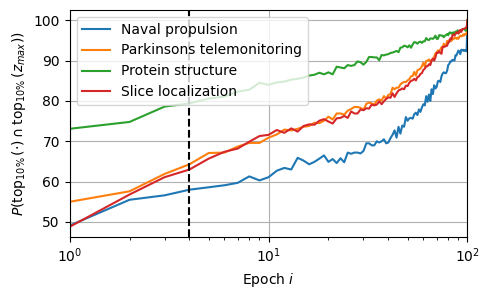

In [227]:
datasets = ["naval_propulsion", "parkinsons_telemonitoring", "protein_structure", "slice_localization"]

plt.figure()

for  dataset in datasets:
    print(f"{dataset=}")
    f = load_dataset(f"fcnet_{dataset}_data")
    
    random_state = 42
    rs = np.random.RandomState(random_state)
    keys = list(f.keys())
    # num_models = len(keys) 
    num_models = 10_000

    selection = rs.choice(keys, size=num_models, replace=False)

    M = []
    for i, k in enumerate(selection):
        C = np.mean(f[k]["valid_loss"], axis=0).tolist()
        M.append(C)
    M = np.asarray(M)

    # ranking matrix per step
    R = rankdata(M, axis=0)

    idx_sorting = np.argsort(R[:,-1])


    perc = []
    for step in x:
        idx_sort_start = np.argsort(M[:,step-1])
        idx_top_start = idx_sort_start[:int(idx_sort_start.shape[0] * 0.1)]

        idx_sort_end = np.argsort(M[:,-1])
        idx_top_end = idx_sort_end[:int(idx_sort_end.shape[0] * 0.1)]

        intersection = np.intersect1d(idx_top_start, idx_top_end)
        perc_common = len(intersection) / len(idx_top_end) * 100
        perc.append(perc_common)

    plt.plot(x, perc, label=dataset.replace("_"," ").capitalize())
    
plt.axvline(x=4, linestyle="--", color="black")
plt.grid()
plt.ylabel(r"$P(\operatorname{top}_{10\%}(\cdot) \cap \operatorname{top}_{10\%}(z_{max}))$")
plt.xlabel(r"Epoch $i$")
plt.xlim(x[0], x[-1])
plt.xscale("log")
plt.legend()
plt.savefig(f"perc_intersection_{dataset}.png")
plt.tight_layout()
plt.show()

## Probability of finding a top-ranking model

In [5]:
from scipy.stats import binom

p = 1 - binom.cdf(k=0, n=10, p=0.8)
p

0.9999998976

In [6]:
from scipy.stats import nbinom

nbinom.pmf(k=1, n=10, p=0.8)

0.21474836480000012

## Visualize Learning Curves with Different Scales

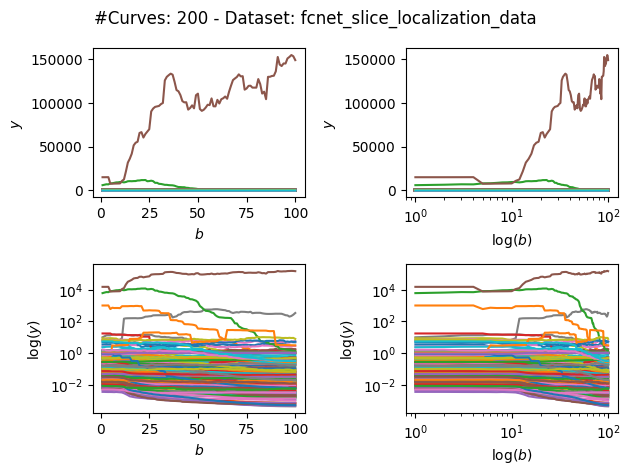

In [13]:
def plot_k_curves(k):
    rs = np.random.RandomState(42)
    selection = rs.choice(list(f.keys()), size=k, replace=False)
    for config in selection:
        y = f[config]["valid_loss"][0]
        y = uniform_filter1d(y, size=25)
        x = np.arange(1, len(y)+1)
        plt.plot(x, y)

k = 200

fig = plt.figure()
fig.suptitle(f"#Curves: {k} - Dataset: {dataset}")

# linear linear
plt.subplot(2, 2, 1)
plot_k_curves(k)
plt.ylabel("$y$")
plt.xlabel("$b$")

# linear linear
plt.subplot(2, 2, 2)
plot_k_curves(k)
plt.ylabel("$y$")
plt.xlabel("$\log(b)$")
plt.xscale("log")

# linear linear
plt.subplot(2, 2, 3)
plot_k_curves(k)
plt.ylabel("$\log(y)$")
plt.xlabel("$b$")
plt.yscale("log")

# linear linear
plt.subplot(2, 2, 4)
plot_k_curves(k)
plt.ylabel("$\log(y)$")
plt.xlabel("$\log(b)$")
plt.yscale("log")
plt.xscale("log")

plt.tight_layout()
plt.savefig(f"sample-curves_{k}_{dataset}.png", dpi=360)
plt.show()

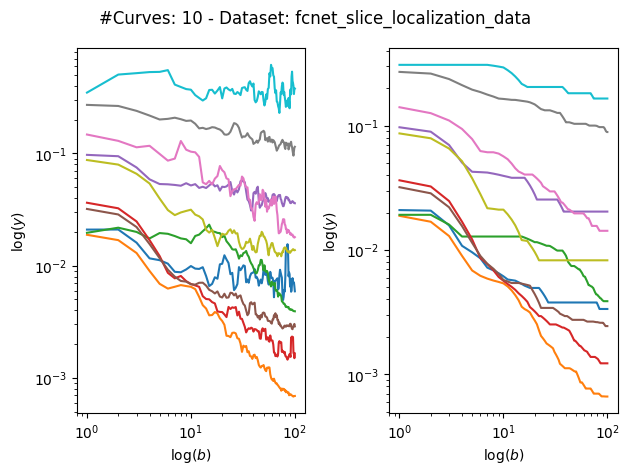

In [19]:
def plot_k_curves(k):
    rs = np.random.RandomState(42)
    selection = rs.choice(list(f.keys()), size=k, replace=False)
    for config in selection:
        y = f[config]["valid_loss"][0]
        y = uniform_filter1d(y, size=5)
        x = np.arange(1, len(y)+1)
        plt.plot(x, y)
        
def plot_k_curves_cummin(k):
    rs = np.random.RandomState(42)
    selection = rs.choice(list(f.keys()), size=k, replace=False)
    for config in selection:
        y = f[config]["valid_loss"][0]
        
        # make monotonic
        y = pd.Series(y).cummin().tolist()

        y = uniform_filter1d(y, size=5)
        
        x = np.arange(1, len(y)+1)
        plt.plot(x, y)

k = 10

fig = plt.figure()
fig.suptitle(f"#Curves: {k} - Dataset: {dataset}")

# linear linear
plt.subplot(1, 2, 1)
plot_k_curves(k)
plt.ylabel("$\log(y)$")
plt.xlabel("$\log(b)$")
plt.yscale("log")
plt.xscale("log")

# linear linear
plt.subplot(1, 2, 2)
plot_k_curves_cummin(k)
plt.ylabel("$\log(y)$")
plt.xlabel("$\log(b)$")
plt.yscale("log")
plt.xscale("log")

plt.tight_layout()
# plt.savefig(f"sample-curves_{k}_{dataset}.png", dpi=360)
plt.show()

In [114]:
from scipy.optimize import least_squares


def f_IPL(b, alpha, beta, gamma): # a Curve
    return alpha + beta * b**-gamma

vf_IPL = np.vectorize(f_IPL)


def df_IPL(b, alpha, beta, gamma): # derivative of the curve
    return - beta * gamma * b**(-gamma-1)

vdf_IPL = np.vectorize(df_IPL)


def u(b, alpha, beta, gamma, lamb, b_max):
    y = C(b, alpha, beta, gamma)
    y_max = C(b_max, alpha, beta, gamma)
    u1 = b * np.log(y / y_max)
    u2 = - b * np.log(b / b_max)
    u3 = b * lamb
    return u1 + u2 + u3

vu = np.vectorize(u)


def du(b, alpha, beta, gamma, lamb, b_max):
    y = C(b, alpha, beta, gamma)
    dy = dC(b, alpha, beta, gamma)
    u_val = u(b, alpha, beta, gamma, lamb, b_max)
    return s*dy/y + u_val/s - 1

vdu = np.vectorize(du)


def loss_f_IPL_least_square(x, b, y):
    # x: parameters, b: budget, y: target
    return (f_IPL(b, alpha=x[0], beta=x[1], gamma=x[2]) - y).flatten()

def jac_least_square(x, b, y):
    return np.zeros((1, 3))


def optimize_IPL_parameters(b, y):
    x0 = np.zeros(3)
    x0[0] = np.min(y)
    x0[1] = np.max(y)
    x0[2] = 0.5
    res_lsq = least_squares(loss_f_IPL_least_square, x0, args=(b, y),
                            loss="soft_l1",
                            f_scale=0.01,
                            bounds=[[10e-12, 10e-12, 10e-12], [np.inf, np.inf, np.inf]]
                           )
    x_sol = res_lsq.x
    return x_sol

IPL_parameters=array([0.0347377 , 0.03588506, 0.95270834])


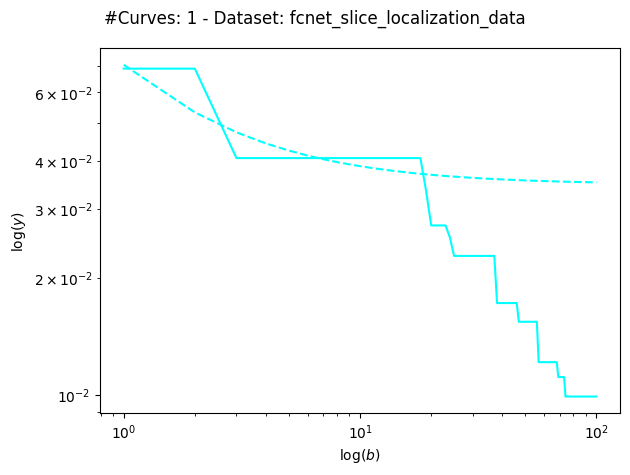

In [122]:
def plot_k_curves_cummin(k):
    rs = np.random.RandomState()
    selection = rs.choice(list(f.keys()), size=k, replace=False)
    colors = ["cyan", "red", "green", "purple", "orange", "navy"]
    for i, config in enumerate(selection):
        y = f[config]["valid_loss"][0]
        
        # make monotonic
        y = pd.Series(y).cummin().tolist()

        # y = uniform_filter1d(y, size=5)
        b_max = 10
        b = np.arange(b_max)+1
        IPL_parameters = optimize_IPL_parameters(b, y[:b_max])
        print(f"{IPL_parameters=}")
        
        x = np.arange(1, len(y)+1)
        plt.plot(x, y, linestyle="-", color=colors[i%len(colors)])
        
        plt.plot(x, vf_IPL(x, *IPL_parameters), linestyle="--", color=colors[i%len(colors)])

k = 1

fig = plt.figure()
fig.suptitle(f"#Curves: {k} - Dataset: {dataset}")

plot_k_curves_cummin(k)
plt.ylabel("$\log(y)$")
plt.xlabel("$\log(b)$")
plt.yscale("log")
plt.xscale("log")

plt.tight_layout()
# plt.savefig(f"sample-curves_{k}_{dataset}.png", dpi=360)
plt.show()

In [74]:
pd.Series([2,1,2,4,2,1]).cummin().tolist()

[2, 1, 1, 1, 1, 1]

## NAS Bench 101

In [1]:
import os

# DIR = os.path.dirname(os.path.abspath(__file__))

from deephyper.evaluator import profile, RunningJob
from deephyper.problem import HpProblem

# hpobench
from hpobench.benchmarks.nas.nasbench_101 import NASCifar10BBenchmark

data_path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data"
b = NASCifar10BBenchmark(data_path=data_path)
config_space = b.get_configuration_space()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Loading dataset from file... This may take a few minutes...
Loaded dataset in 67 seconds


In [7]:
problem = HpProblem(config_space=config_space)
problem

Configuration space object:
  Hyperparameters:
    edge_0, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_1, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_2, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_3, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_4, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_5, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_6, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, Default: 0
    edge_7, Type: Categorical, Choices: {0, 1, 2, 3, 4, 5, 6, 7,

In [6]:
budget_space = b.get_fidelity_space().get("budget")
min_b, max_b = budget_space.sequence[0], budget_space.sequence[-1]

In [20]:
# config = problem.default_configuration
config = dict(problem.space.sample_configuration())

In [21]:
b.objective_function(config, fidelity={"budget": max_b})

{'function_value': 0.1659655372301737,
 'cost': 853.5010070800781,
 'info': {'fidelity': {'budget': 108},
  'train_accuracies': [0.9788661599159241,
   0.9789663553237915,
   0.9769631624221802],
  'valid_accuracies': [0.8358373641967773,
   0.8316305875778198,
   0.8346354365348816],
  'test_accuracies': [0.8410456776618958, 0.8359375, 0.8361378312110901],
  'training_times': [284.24298095703125,
   285.03802490234375,
   284.2200012207031],
  'data': {'trainable_parameters': 882570,
   'module_operations': ['input', 'output']}}}

In [22]:
b.objective_function(config, fidelity={"budget": min_b})

{'function_value': 0.47686296701431274,
 'cost': 42.69700050354004,
 'info': {'fidelity': {'budget': 4},
  'train_accuracies': [0.5596955418586731,
   0.5677083134651184,
   0.5016025900840759],
  'valid_accuracies': [0.5404647588729858,
   0.5467748641967773,
   0.4821714758872986],
  'test_accuracies': [0.5368589758872986,
   0.5464743375778198,
   0.4826722741127014],
  'training_times': [14.211999893188477,
   14.187000274658203,
   14.29800033569336],
  'data': {'trainable_parameters': 882570,
   'module_operations': ['input', 'output']}}}

In [25]:
from hpobench.benchmarks.nas.nasbench_201 import Cifar10ValidNasBench201BenchmarkOriginal

b = Cifar10ValidNasBench201BenchmarkOriginal()
config_space = b.get_configuration_space()

problem = HpProblem(config_space=config_space)
problem

Configuration space object:
  Hyperparameters:
    1<-0, Type: Categorical, Choices: {none, skip_connect, nor_conv_1x1, nor_conv_3x3, avg_pool_3x3}, Default: none
    2<-0, Type: Categorical, Choices: {none, skip_connect, nor_conv_1x1, nor_conv_3x3, avg_pool_3x3}, Default: none
    2<-1, Type: Categorical, Choices: {none, skip_connect, nor_conv_1x1, nor_conv_3x3, avg_pool_3x3}, Default: none
    3<-0, Type: Categorical, Choices: {none, skip_connect, nor_conv_1x1, nor_conv_3x3, avg_pool_3x3}, Default: none
    3<-1, Type: Categorical, Choices: {none, skip_connect, nor_conv_1x1, nor_conv_3x3, avg_pool_3x3}, Default: none
    3<-2, Type: Categorical, Choices: {none, skip_connect, nor_conv_1x1, nor_conv_3x3, avg_pool_3x3}, Default: none

In [33]:
budget_space = b.get_fidelity_space().get("epoch")
min_b, max_b = budget_space.lower, budget_space.upper

In [34]:
config = dict(problem.space.sample_configuration())

In [36]:
b.objective_function(config, fidelity={"epoch": max_b})

{'function_value': 13.55466666585285,
 'cost': 6284.504669589668,
 'info': {'train_precision': 1.6239999967447858,
  'train_losses': 0.06142843915303548,
  'train_cost': 4604.401473939428,
  'valid_precision': 13.55466666585285,
  'valid_losses': 0.5217159519958496,
  'valid_cost': 6284.504669589668,
  'test_precision': 13.55466666585285,
  'test_losses': 0.5217159519958496,
  'test_cost': 5276.442752199525,
  'fidelity': {'epoch': 200}}}